In [1]:
import pandas as pd
import xarray as xr
import seaborn as sns
import xscale
from matplotlib import pyplot as plt
from scipy import stats
import ocean_data_tools as odt

%matplotlib inline

In [2]:
def xarray_trend(xarr):
    """
    Calculates the trend of the data along the 'time' dimension
    of the input array (xarr).
    USAGE:  x_DS = xarray_trend(xarr)
    INPUT:  xarr is an xarray DataArray with dims:
                time, [lat, lon]
                where lat and/or lon are optional
    OUTPUT: xArray Dataset with:
                original xarr input
                slope
                p-value
    TODO?
    There could be speed improvements (using numpy at the moment)
    """

    from scipy import stats
    # getting shapes

    n = xarr.shape[0]

    # creating x and y variables for linear regression
    x = xarr.ocean_time.to_pandas().index.to_julian_date().values[:, None]
    y = xarr.to_masked_array().reshape(n, -1)

    # ############################ #
    # LINEAR REGRESSION DONE BELOW #
    xm = x.mean(0)  # mean
    ym = y.mean(0)  # mean
    ya = y - ym  # anomaly
    xa = x - xm  # anomaly

    # variance and covariances
    xss = (xa ** 2).sum(0) / (n - 1)  # variance of x (with df as n-1)
    yss = (ya ** 2).sum(0) / (n - 1)  # variance of y (with df as n-1)
    xys = (xa * ya).sum(0) / (n - 1)  # covariance (with df as n-1)
    # slope and intercept
    slope = xys / xss
    # statistics about fit
    df = n - 2
    r = xys / (xss * yss)**0.5
    t = r * (df / ((1 - r) * (1 + r)))**0.5
    p = stats.distributions.t.sf(abs(t), df)

    # misclaneous additional functions
    intercept = ym - (slope * xm)
    # yhat = dot(x, slope[None]) + intercept
    # sse = ((yhat - y)**2).sum(0) / (n - 2)  # n-2 is df
    # se = ((1 - r**2) * yss / xss / df)**0.5

    # preparing outputs
    out = xarr.to_dataset(name=xarr.name)
    # first create variable for slope and adjust meta
    out['slope'] = xarr[:2].mean('ocean_time').copy()
    out['slope'].name += '_slope'
    out['slope'].attrs['units'] = 'units / day'
    out['slope'].values = slope.reshape(xarr.shape[1:])
    # do the same for the p value
    out['pval'] = xarr[:2].mean('ocean_time').copy()
    out['pval'].name += '_Pvalue'
    out['pval'].values = p.reshape(xarr.shape[1:])
    out['pval'].attrs['info'] = ("If p < 0.05 then the results "
                                 "from 'slope' are significant.")
    # do the same for the intercept
    out['intercept'] = xarr[:2].mean('ocean_time').copy()
    out['intercept'].name += '_intercept'
    out['intercept'].values = intercept.reshape(xarr.shape[1:])
    

    return out

## This notebook makes pretty stats plots of the ROMS heatbudgets, using .nc files created in the individual box heat budget notebooks

In [3]:
# import data
SEQ = xr.open_dataset('SEQ_budget_th_box.nc')
CH = xr.open_dataset('CH_budget_th_box.nc')
SYD = xr.open_dataset('SYD_budget_th_box.nc')
BMP = xr.open_dataset('BMP_budget_th_box.nc')

time_slice = dict(ocean_time=slice('1995-01-01', '2016-12-31'))
SEQ=SEQ.sel(**time_slice)
CH=CH.sel(**time_slice)
SYD=SYD.sel(**time_slice)
BMP=BMP.sel(**time_slice)

In [4]:
# Define timeseries plotting function
'''function to plot time series. Site is a xarray dataset, name is a string, filt is number of days to filter'''
def plot_timeseries(site,name,filt):
    
#     truth = site.total_tendency_TH_truth
#     wt = truth.window
#     wt.set(n=filt, dim='ocean_time', window='hanning')
#     truth = wt.convolve()
#     truth.plot(label='TEND')
    
    SURF = site.conv_vert_diff_flux_TH
    wt = SURF.window
    wt.set(n=filt, dim='ocean_time', window='hanning')
    SURF = wt.convolve()
    SURF.plot(label='SURF')
    
    #trend of annual means
    site_annual_means = SURF.groupby('ocean_time.year').mean('ocean_time')
    #use earl's method for plotting trendline:
    site_slope, site_intercept, site_rvalue, site_pvalue, site_stderr = stats.linregress(site_annual_means.year, site_annual_means)
    #plt.plot(site_annual_means.year,site_annual_means)
    x_site = [site_annual_means.year.isel(year=0), site_annual_means.year.isel(year=-1)]
    # slope * x + intercept
    y_site = [site_slope*x_site[0] + site_intercept, site_slope*x_site[1] + site_intercept]
    #plt.plot(x_site,y_site)
    plt.plot([site.ocean_time[0].values,site.ocean_time[-1].values],y_site,color='C0',linestyle='--')
    
    ADV = (site.conv_horiz_adv_flux_TH + site.conv_vert_adv_flux_TH+site.conv_horiz_diff_flux_TH)
    wt = ADV.window
    wt.set(n=filt, dim='ocean_time', window='hanning')
    ADV = wt.convolve()
    ADV.plot(label='ADV')
    
    #trend of annual means
    site_annual_means = (site.conv_horiz_adv_flux_TH + site.conv_vert_adv_flux_TH+site.conv_horiz_diff_flux_TH).groupby('ocean_time.year').mean('ocean_time')
    #use earl's method for plotting trendline:
    site_slope, site_intercept, site_rvalue, site_pvalue, site_stderr = stats.linregress(site_annual_means.year, site_annual_means)
    #plt.plot(site_annual_means.year,site_annual_means)
    x_site = [site_annual_means.year.isel(year=0), site_annual_means.year.isel(year=-1)]
    # slope * x + intercept
    y_site = [site_slope*x_site[0] + site_intercept, site_slope*x_site[1] + site_intercept]
    #plt.plot(x_site,y_site)
    plt.plot([site.ocean_time[0].values,site.ocean_time[-1].values],y_site,color='C1',linestyle='--')
    
    
    
    
#     DIFF = site.conv_horiz_diff_flux_TH
#     wt = DIFF.window
#     wt.set(n=filt, dim='ocean_time', window='hanning')
#     DIFF = wt.convolve()  
#     DIFF.plot(label='DIFF')
    plt.legend(loc='lower left',ncol=2)
    plt.grid()
    plt.axhline(y=0, color='black', linestyle='--')
    plt.title(f'Heat budget terms {name}')
    plt.ylabel('temperature rate of change [degC/day]')
    plt.xlabel('')
    plt.ylim(-0.025,0.025)

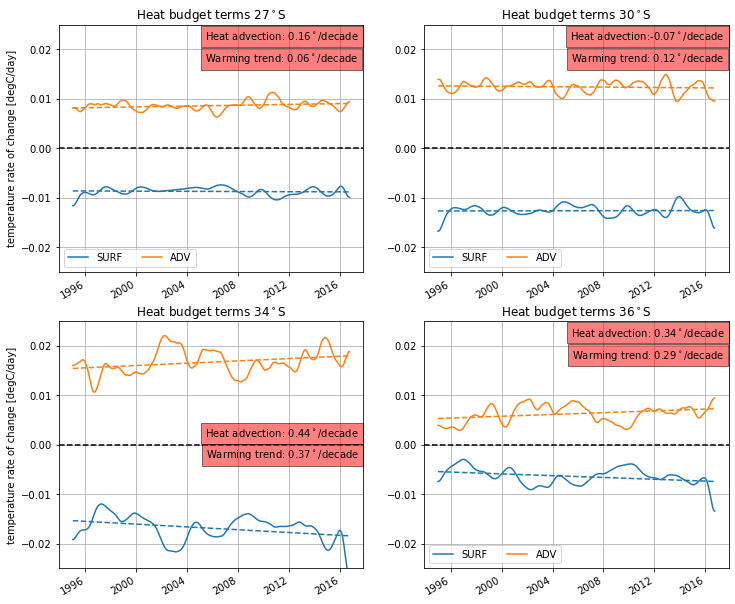

In [5]:
fig= plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
filt = 730
plot_timeseries(SEQ,'27$^\circ$S',filt)
ax = plt.gca()
plt.text(.48,.85,'Warming trend: 0.06$^\circ$/decade',transform=ax.transAxes,bbox=dict(facecolor='red', alpha=0.5))
plt.text(.48,.94,'Heat advection: 0.16$^\circ$/decade',transform=ax.transAxes,bbox=dict(facecolor='red', alpha=0.5))

plt.subplot(2,2,2)
plot_timeseries(CH,'30$^\circ$S',filt)
ax = plt.gca()
plt.text(.481,.85,'Warming trend: 0.12$^\circ$/decade',transform=ax.transAxes,bbox=dict(facecolor='red', alpha=0.5))
plt.text(.48,.94,'Heat advection:-0.07$^\circ$/decade',transform=ax.transAxes,bbox=dict(facecolor='red', alpha=0.5))
plt.ylabel('')
    
plt.subplot(2,2,3)
plot_timeseries(SYD,'34$^\circ$S',filt)
ax = plt.gca()
plt.text(.484,.448,'Warming trend: 0.37$^\circ$/decade',transform=ax.transAxes,bbox=dict(facecolor='red', alpha=0.5))
plt.text(.481,.532,'Heat advection: 0.44$^\circ$/decade',transform=ax.transAxes,bbox=dict(facecolor='red', alpha=0.5))

ax.get_legend().remove()

plt.subplot(2,2,4)
plot_timeseries(BMP,'36$^\circ$S',filt)
ax = plt.gca()
plt.text(.485,.85,'Warming trend: 0.29$^\circ$/decade',transform=ax.transAxes,bbox=dict(facecolor='red', alpha=0.5))
plt.text(.483,.94,'Heat advection: 0.34$^\circ$/decade',transform=ax.transAxes,bbox=dict(facecolor='red', alpha=0.5))
plt.ylabel('')
plt.savefig('combined_filt_4yr_heat_terms_annual_mean.png', dpi=300,bbox_inches='tight')

0.3430294361527329

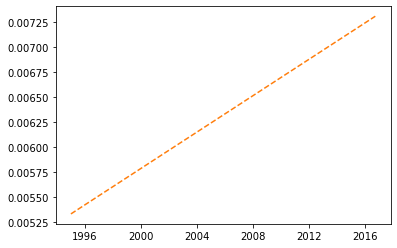

In [10]:
site=BMP
#trend of annual means
site_annual_means = (site.conv_horiz_adv_flux_TH + site.conv_vert_adv_flux_TH+site.conv_horiz_diff_flux_TH).groupby('ocean_time.year').mean('ocean_time')
#use earl's method for plotting trendline:
site_slope, site_intercept, site_rvalue, site_pvalue, site_stderr = stats.linregress(site_annual_means.year, site_annual_means)
#plt.plot(site_annual_means.year,site_annual_means)
x_site = [site_annual_means.year.isel(year=0), site_annual_means.year.isel(year=-1)]
# slope * x + intercept
y_site = [site_slope*x_site[0] + site_intercept, site_slope*x_site[1] + site_intercept]
#plt.plot(x_site,y_site)
plt.plot([site.ocean_time[0].values,site.ocean_time[-1].values],y_site,color='C1',linestyle='--')
adv_trend=site_slope*3650
adv_trend

-0.37705652559148384

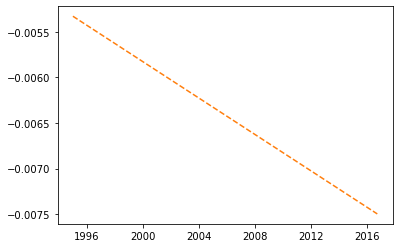

In [14]:
site=BMP
#trend of annual means
site_annual_means = (site.conv_vert_diff_flux_TH).groupby('ocean_time.year').mean('ocean_time')
#use earl's method for plotting trendline:
site_slope, site_intercept, site_rvalue, site_pvalue, site_stderr = stats.linregress(site_annual_means.year, site_annual_means)
#plt.plot(site_annual_means.year,site_annual_means)
x_site = [site_annual_means.year.isel(year=0), site_annual_means.year.isel(year=-1)]
# slope * x + intercept
y_site = [site_slope*x_site[0] + site_intercept, site_slope*x_site[1] + site_intercept]
#plt.plot(x_site,y_site)
plt.plot([site.ocean_time[0].values,site.ocean_time[-1].values],y_site,color='C1',linestyle='--')
adv_trend=site_slope*3650
adv_trend

In [7]:
time_slice = dict(ocean_time=slice(0, 365))

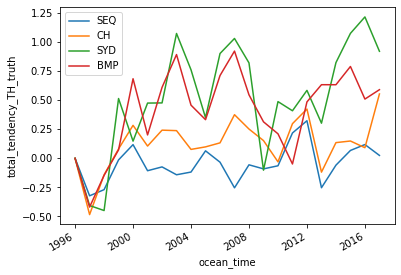

In [8]:
(SEQ.total_tendency_TH_truth.cumsum()-SEQ.total_tendency_TH_truth.cumsum().isel(**time_slice).mean()).resample(ocean_time='1Y').mean().plot(label='SEQ')
(CH.total_tendency_TH_truth.cumsum()-CH.total_tendency_TH_truth.cumsum().isel(**time_slice).mean()).resample(ocean_time='1Y').mean().plot(label='CH')
(SYD.total_tendency_TH_truth.cumsum()-SYD.total_tendency_TH_truth.cumsum().isel(**time_slice).mean()).resample(ocean_time='1Y').mean().plot(label='SYD')
(BMP.total_tendency_TH_truth.cumsum()-BMP.total_tendency_TH_truth.cumsum().isel(**time_slice).mean()).resample(ocean_time='1Y').mean().plot(label='BMP')
plt.legend()

In [20]:
#temperature trend
test = CH.total_tendency_TH_truth.cumsum().stats.trend()
test.slope*3650

<xarray.DataArray 'slope' ()>
array(0.12591156)

In [22]:
#surf trend
test = CH.conv_vert_diff_flux_TH.stats.trend()
test.slope*3650

<xarray.DataArray 'slope' ()>
array(8.87377499e-05)

In [25]:
#ADV trend
site = CH
test = (site.conv_horiz_adv_flux_TH + site.conv_vert_adv_flux_TH+site.conv_horiz_diff_flux_TH).stats.trend()
test.slope*3650

<xarray.DataArray 'slope' ()>
array(-0.00027382)

In [9]:
#calculate TEND trend
SEQ["TEND"]=(SEQ.total_tendency_TH_truth)
SEQ.TEND.rename({'ocean_time':'time'})
x = xarray_trend(SEQ.TEND)
decade_trend_SEQ = x.slope*3650
decade_trend_SEQ

<xarray.DataArray 'slope' ()>
array(0.00019153)

In [10]:
#calculate SURF trend
SEQ["SURF"]=(SEQ.conv_vert_diff_flux_TH)
SEQ.SURF.rename({'ocean_time':'time'})
x = xarray_trend(SEQ.SURF)
decade_trend_SEQ = x.slope*3650
decade_trend_SEQ

<xarray.DataArray 'slope' ()>
array(-9.59594261e-05)

In [11]:
#calculate advection trend
SEQ["ADV"]=(SEQ.conv_horiz_adv_flux_TH + SEQ.conv_vert_adv_flux_TH)
SEQ.ADV.rename({'ocean_time':'time'})
x = xarray_trend(SEQ.ADV)
decade_trend_SEQ = x.slope*3650
decade_trend_SEQ

<xarray.DataArray 'slope' ()>
array(0.00051491)

In [12]:
#calculate diffusion trend
SEQ["DIFF"]=(SEQ.conv_horiz_diff_flux_TH)
SEQ.DIFF.rename({'ocean_time':'time'})
x = xarray_trend(SEQ.DIFF)
decade_trend_SEQ = x.slope*3650
decade_trend_SEQ

<xarray.DataArray 'slope' ()>
array(-0.00022742)

Text(0.52, 0.65, 'Warming trend: 0.12$^\\circ$/decade')

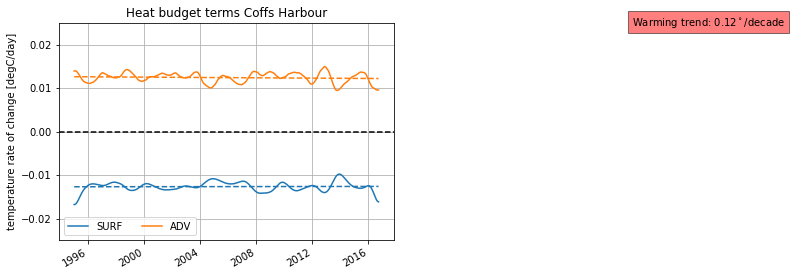

In [13]:
plot_timeseries(CH,'Coffs Harbour',filt)
plt.text(.52,.65,'Warming trend: 0.12$^\circ$/decade',transform=ax.transAxes,bbox=dict(facecolor='red', alpha=0.5))
#plt.savefig('filt_4yr_CH_heat_terms_annual_mean.png', dpi=300,bbox_inches='tight')

In [14]:
#calculate TEND trend
CH["SURF"]=(CH.total_tendency_TH_truth)
CH.SURF.rename({'ocean_time':'time'})
x = xarray_trend(CH.SURF)
decade_trend_CH = x.slope*3650
decade_trend_CH

<xarray.DataArray 'slope' ()>
array(-0.00018509)

In [15]:
#calculate advection trend
CH["ADV"]=(CH.conv_horiz_adv_flux_TH + CH.conv_vert_adv_flux_TH)
CH.ADV.rename({'ocean_time':'time'})
x = xarray_trend(CH.ADV)
decade_trend_CH = x.slope*3650
decade_trend_CH

<xarray.DataArray 'slope' ()>
array(0.00190049)

In [16]:
#calculate SURF trend
CH["SURF"]=(CH.conv_vert_diff_flux_TH)
CH.SURF.rename({'ocean_time':'time'})
x = xarray_trend(CH.SURF)
decade_trend_CH = x.slope*3650
decade_trend_CH

<xarray.DataArray 'slope' ()>
array(8.87377499e-05)

In [17]:
#calculate diffusion trend
CH["DIFF"]=(CH.conv_horiz_diff_flux_TH)
CH.DIFF.rename({'ocean_time':'time'})
x = xarray_trend(CH.DIFF)
decade_trend_CH = x.slope*3650
decade_trend_CH

<xarray.DataArray 'slope' ()>
array(-0.00217431)

In [18]:
x = xarray_trend(CH.total_tendency_TH_truth)
decade_trend_CH = x.slope*3650
decade_trend_CH

<xarray.DataArray 'slope' ()>
array(-0.00018509)

Text(0.54, 0.65, 'Warming trend: 0.37$^\\circ$/decade')

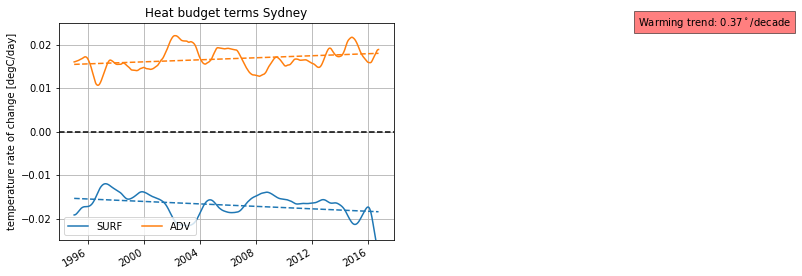

In [19]:
plot_timeseries(SYD,'Sydney',filt)
plt.text(.54,.65,'Warming trend: 0.37$^\circ$/decade',transform=ax.transAxes,bbox=dict(facecolor='red', alpha=0.5))
#plt.savefig('filt_4yr_SYD_heat_terms_annual_mean.png', dpi=300,bbox_inches='tight')

In [20]:
#calculate TEND trend
SYD["SURF"]=(SYD.total_tendency_TH_truth)
SYD.SURF.rename({'ocean_time':'time'})
x = xarray_trend(SYD.SURF)
decade_trend_SYD = x.slope*3650
decade_trend_SYD

<xarray.DataArray 'slope' ()>
array(-0.00033857)

In [21]:
#calculate advection trend
SYD["ADV"]=(SYD.conv_horiz_adv_flux_TH + SYD.conv_vert_adv_flux_TH)
SYD.ADV.rename({'ocean_time':'time'})
x = xarray_trend(SYD.ADV)
decade_trend_SYD = x.slope*3650
decade_trend_SYD

<xarray.DataArray 'slope' ()>
array(0.00114015)

In [22]:
#calculate SURF trend
SYD["SURF"]=(SYD.conv_vert_diff_flux_TH)
SYD.SURF.rename({'ocean_time':'time'})
x = xarray_trend(SYD.SURF)
decade_trend_SYD = x.slope*3650
decade_trend_SYD

<xarray.DataArray 'slope' ()>
array(-0.00136795)

In [23]:
#calculate diffusion trend
SYD["DIFF"]=(SYD.conv_horiz_diff_flux_TH)
SYD.DIFF.rename({'ocean_time':'time'})
x = xarray_trend(SYD.DIFF)
decade_trend_SYD = x.slope*3650
decade_trend_SYD

<xarray.DataArray 'slope' ()>
array(-0.00011077)

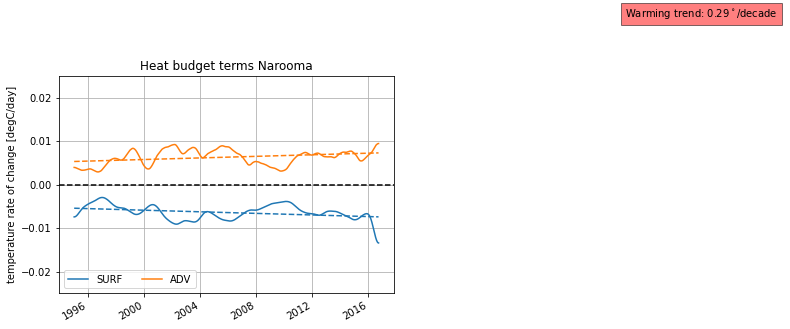

In [24]:
plot_timeseries(BMP,'Narooma',filt)
plt.text(.5,.9,'Warming trend: 0.29$^\circ$/decade',transform=ax.transAxes,bbox=dict(facecolor='red', alpha=0.5))
plt.savefig('filt_4yr_BMP_heat_terms_annual_mean.png', dpi=300,bbox_inches='tight')

In [25]:
#calculate TEND trend
BMP["SURF"]=(BMP.total_tendency_TH_truth)
BMP.SURF.rename({'ocean_time':'time'})
x = xarray_trend(BMP.SURF)
decade_trend_BMP = x.slope*3650
decade_trend_BMP

<xarray.DataArray 'slope' ()>
array(-0.00015463)

In [26]:
#calculate advection trend
BMP["ADV"]=(BMP.conv_horiz_adv_flux_TH + BMP.conv_vert_adv_flux_TH)
BMP.ADV.rename({'ocean_time':'time'})
x = xarray_trend(BMP.ADV)
decade_trend_BMP = x.slope*3650
decade_trend_BMP

<xarray.DataArray 'slope' ()>
array(-0.00073331)

In [27]:
#calculate SURF trend
BMP["SURF"]=(BMP.conv_vert_diff_flux_TH)
BMP.SURF.rename({'ocean_time':'time'})
x = xarray_trend(BMP.SURF)
decade_trend_BMP = x.slope*3650
decade_trend_BMP

<xarray.DataArray 'slope' ()>
array(-0.00087139)

In [28]:
#calculate diffusion trend
BMP["DIFF"]=(BMP.conv_horiz_diff_flux_TH)
BMP.DIFF.rename({'ocean_time':'time'})
x = xarray_trend(BMP.DIFF)
decade_trend_BMP = x.slope*3650
decade_trend_BMP

<xarray.DataArray 'slope' ()>
array(0.00145006)

In [29]:
# Define box plotting function
'''function to plot box plots. Site is a xarray dataset, name is a string'''
def plotBox(site,name):
    ADV = site.conv_horiz_adv_flux_TH + site.conv_vert_adv_flux_TH
    df = pd.DataFrame({f'{name}':['TEND', 'ADV', 'SURF'], 'contribution':[site.total_tendency_TH_truth
                                                             ,ADV
                                                             ,site.conv_vert_diff_flux_TH]})
    sns.set(style="whitegrid", palette="pastel", color_codes=True)
    foo = df.explode('contribution')
    foo['contribution'] = foo['contribution'].astype('float')
    ax = sns.boxplot(data=foo, x=f'{name}', y='contribution',width=0.5,showfliers=False)
    ax.set(ylabel='temperature rate of change [$^{o}$C/s]')
    plt.ylim(-0.5,0.5)

(-0.5, 0.5)

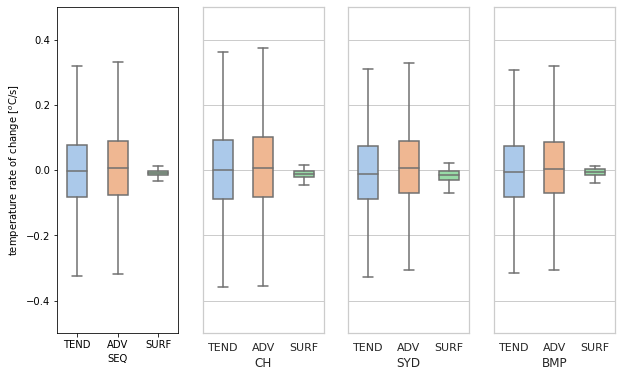

In [30]:
fig = plt.figure(figsize=(10,6))
a = plt.subplot(1,4,1)
plotBox(SEQ,'SEQ')
b = plt.subplot(1,4,2)
plotBox(CH,'CH')
b.set_yticklabels([])
plt.ylabel('')
c = plt.subplot(1,4,3)
plotBox(SYD,'SYD')
plt.ylabel('')
c.set_yticklabels([])
d = plt.subplot(1,4,4)
plotBox(BMP,'BMP')
d.set_yticklabels([])
plt.ylabel('')
plt.ylim()
#plt.savefig('EAC_heat_terms_boxplot.png', dpi=300,bbox_inches='tight')

In [41]:
# Define minimal bar plotting function
'''function to plot bar plots. Site is a xarray dataset, name is a string'''
def plotBarmin(site,name):
    ADV = (site.conv_horiz_adv_flux_TH + site.conv_vert_adv_flux_TH+site.conv_horiz_diff_flux_TH)
    df = pd.DataFrame({f'{name}':['ADV', 'SURF'], 'contribution':[ADV, site.conv_vert_diff_flux_TH]})
    sns.set(style="whitegrid", palette=['tab:orange','tab:blue'], color_codes=True)
    foo = df.explode('contribution')
    foo['contribution'] = foo['contribution'].astype('float')
    ax = sns.barplot(data=foo, x=f'{name}', y='contribution',capsize=.2,edgecolor=(0,0,0),linewidth=1)
    ax.set(ylabel='temperature rate of change [$^{\circ}$C/day]')
    plt.ylim(-0.018,0.022)

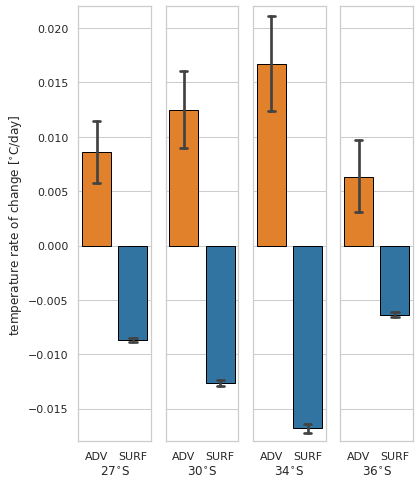

In [44]:
fig = plt.figure(figsize=(6,8))
a = plt.subplot(1,4,1)
plotBarmin(SEQ,'SEQ')
plt.xlabel('27$^{\circ}$S');
b = plt.subplot(1,4,2)
plotBarmin(CH,'CH')
plt.xlabel('30$^{\circ}$S');
b.set_yticklabels([])
plt.ylabel('')
c = plt.subplot(1,4,3)
plotBarmin(SYD,'SYD')
plt.xlabel('34$^{\circ}$S');
plt.ylabel('')
c.set_yticklabels([])
d = plt.subplot(1,4,4)
plotBarmin(BMP,'BMP')
plt.xlabel('36$^{\circ}$S');
d.set_yticklabels([])
plt.ylabel('')
plt.ylim()
plt.savefig('EAC_heat_terms_bar_minplot.png', dpi=300,bbox_inches='tight')

In [33]:
# Define bar plotting function
'''function to plot bar plots. Site is a xarray dataset, name is a string'''
def plotBar(site,name):
    ADV = site.conv_horiz_adv_flux_TH #+ site.conv_vert_adv_flux_TH
    DIFF = site.conv_vert_adv_flux_TH
    df = pd.DataFrame({f'{name}':['TEND', 'ADV', 'DIFF', 'SURF'], 'contribution':[site.total_tendency_TH_truth
                                                             ,ADV, DIFF
                                                             ,site.conv_vert_diff_flux_TH]})
    sns.set(style="whitegrid", palette="pastel", color_codes=True)
    foo = df.explode('contribution')
    foo['contribution'] = foo['contribution'].astype('float')
    ax = sns.barplot(data=foo, x=f'{name}', y='contribution', capsize=.2)
    ax.set(ylabel='temperature rate of change [$^{o}$C/day]')
    plt.ylim(-0.001,0.001)

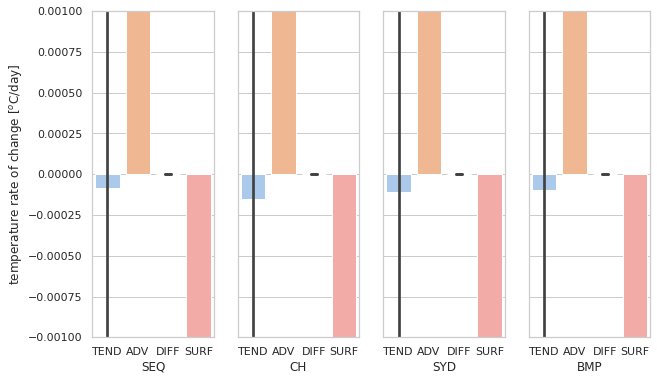

In [34]:
fig = plt.figure(figsize=(10,6))
a = plt.subplot(1,4,1)
plotBar(SEQ,'SEQ')
b = plt.subplot(1,4,2)
plotBar(CH,'CH')
b.set_yticklabels([])
plt.ylabel('')
c = plt.subplot(1,4,3)
plotBar(SYD,'SYD')
plt.ylabel('')
c.set_yticklabels([])
d = plt.subplot(1,4,4)
plotBar(BMP,'BMP')
d.set_yticklabels([])
plt.ylabel('')
plt.ylim()
plt.savefig('EAC_heat_terms_barplot.png', dpi=300,bbox_inches='tight')

In [ ]:
sns.reset_orig()